In [1]:
!wget https://datasets-humai.s3.amazonaws.com/datasets/titanic.csv

--2020-11-09 20:00:35--  https://datasets-humai.s3.amazonaws.com/datasets/titanic.csv
Resolving datasets-humai.s3.amazonaws.com (datasets-humai.s3.amazonaws.com)... 52.216.144.227
Connecting to datasets-humai.s3.amazonaws.com (datasets-humai.s3.amazonaws.com)|52.216.144.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60326 (59K) [text/csv]
Saving to: ‘titanic.csv.1’

titanic.csv.1       100%[===================>]  58.91K  --.-KB/s    in 0.002s  

2020-11-09 20:00:35 (36.8 MB/s) - ‘titanic.csv.1’ saved [60326/60326]



## Machine learning from disaster

En esta notebook vamos a analizar los datos de sobrevivientes del Titanic y a construir un pipeline de inferencia que nos permita predecir cuál era la probabilidad de sobrevivir de cada pasajero.

Finalmente, vamos a evaluar cuál era la probabilidad de supervivencia de los protagonistas de la película: Jack y Rose. 

### Análisis exploratorio de datos

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('titanic.csv',sep='|')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Evaluando el balanceo de la clase

La primera pregunta: ¿Cuántos casos tenemos de cada clase? Si los datos están muy desbalanaceados podemos evaluar técnicas de Resampling.

In [5]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Otras exploraciones de los datos

In [6]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

¿Cuántos pasajeros había en cada clase?

In [7]:
df['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

¿Cuántos son hombres y cuántos mujeres?

In [8]:
df['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [9]:
df['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

¿Cómo se distribuye la edad?

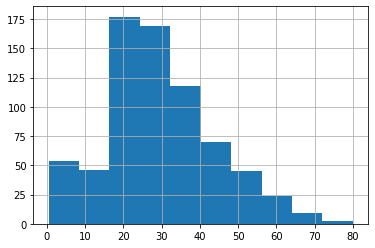

In [10]:
df['Age'].hist();

¿Cómo se distribuye la tarifa pagada?

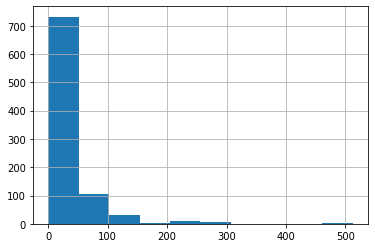

In [11]:
df['Fare'].hist();

#### Descartando variables específicas

El ID de pasajero, el número de ticket y el número de cabina son variables demasiado específicas como para aprovecharlas en una predicción. Podemos descartarlas. Lo mismo podemos decir del nombre. 


In [12]:
df = df.drop(['PassengerId','Cabin','Ticket','Name'],axis=1)

#### Calculando las variables Dummy

Ahora tenemos que transformar las categóricas en representaciones numéricas que nuestro algoritmo pueda entender. 


In [13]:
df_dummies = pd.get_dummies(df)

In [14]:
df_dummies.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Matriz de correlaciones


In [15]:
corr = df_dummies.corr()
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.081720
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.166603
Sex_female,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.125722
Sex_male,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,0.074115,-0.074115,-0.148258,1.000000,-0.496624


### Revisión de valores faltantes

Evaluemos ahora los valores faltantes. Una buena estrategia de imputación para empezar es reemplazar los valores faltantes en columnas numéricas con la mediana y en columnas categóricas con el valore más frecuente. 

In [16]:
df.isnull().sum(axis = 0)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

### Separación de datos entre train y test

In [17]:
X = df.drop('Survived',axis=1)
y = df['Survived']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Pipeline de inferencia

Para tener un modelo robusto, necesitamos crear un pipeline de inferencia que realice todos los pasos necesarios de pre-procesamiento (por ejemplo el cálculo de variables dummies) y realice también la imputación cuando los datos son faltantes. 

In [19]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])



clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex',
                                                   'Pcla

### Predicción sobre los datos de prueba y evaluación del modelo

In [20]:
predicciones = clf.predict_proba(X_test)

In [21]:
predicciones

array([[0.19444444, 0.80555556],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [0.78      , 0.22      ],
       [0.99      , 0.01      ],
       [0.01      , 0.99      ],
       [0.75      , 0.25      ],
       [1.        , 0.        ],
       [0.80333694, 0.19666306],
       [0.        , 1.        ],
       [0.73      , 0.27      ],
       [0.96      , 0.04      ],
       [0.32      , 0.68      ],
       [0.83      , 0.17      ],
       [0.03      , 0.97      ],
       [0.99      , 0.01      ],
       [0.79      , 0.21      ],
       [0.02      , 0.98      ],
       [0.98      , 0.02      ],
       [0.01      , 0.99      ],
       [0.66      , 0.34      ],
       [0.05      , 0.95      ],
       [0.93333333, 0.06666667],
       [0.29      , 0.71      ],
       [0.        , 1.        ],
       [0.57      , 0.43      ],
       [0.68      , 0.32      ],
       [0.61      , 0.39      ],
       [0.16444444, 0.83555556],
       [1.        , 0.        ],
       [0.

In [22]:
# Vamos a quedarnos con todas las filas y la primera columna
preds_proba = predicciones[:,1]

In [23]:
preds_exacta = predicciones.argmax(axis=1)

In [24]:
preds_exacta

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1])

#### Matriz de confusión

In [25]:
df_cm = confusion_matrix(y_test.values,preds_exacta)

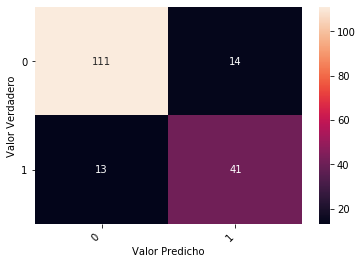

In [26]:
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels([0,1], rotation=0, ha='right')
heatmap.xaxis.set_ticklabels([0,1], rotation=45, ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho');

#### Área debajo de la curva

¿Cuál es la calidad del ordenamiento que hace este modelo a través de las probabilidades predichas?

In [27]:
roc_auc_score(y_test,preds_proba)

0.8705185185185186

### ¿Qué pasará con Jack y Rose?

In [28]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
706,2,female,45.0,0,0,13.5000,S
302,3,male,19.0,0,0,0.0000,S
778,3,male,NaN,0,0,7.7375,Q
657,3,female,32.0,1,1,15.5000,Q
839,1,male,NaN,0,0,29.7000,C


In [29]:
Jack = {'Pclass':3, 'Sex':'male', 'Age':21, 'SibSp':0, 'Parch':0, 'Fare':None, 'Embarked':'Q'}
Rose = {'Pclass':1, 'Sex':'female', 'Age':21, 'SibSp':1, 'Parch':1, 'Fare':None, 'Embarked':'S'}

In [30]:
df_Jack_Rose = pd.DataFrame([Jack, Rose])

In [31]:
pd.DataFrame(clf.predict_proba(df_Jack_Rose), columns = ['No Survived','Survived'], index=['Jack','Rose'])

,No Survived,Survived
Jack,0.880000,0.120000
Rose,0.043333,0.956667
